In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt

In [2]:
#tf.debugging.set_log_device_placement(True)

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Preprocessing: Tokenize, clean-up, load, padding

### Tokenize and clean up data

In [5]:
# Lower case for the translation
# Load original english text as is
# install requirement.txt
# python -m spacy download fr_core_news_sm
# correction of tokenizer.py: add encoding='utf-8' to open method
# same thing for punctuation_remover.py
# python tokenizer.py --input train.lang2 --output tokenized --lang fr --keep-empty-lines
# python punctuation_remover.py --input train.lang2.tok --output tokenized


### Loading data 

In [107]:
# Load data
DIRECTORY_URL = "D:\\IFT6759\\Project2\\data\\train\\"
FILE_NAMES = ["train.lang1","train.lang2.tok"]

en_data = tf.data.TextLineDataset(os.path.join(DIRECTORY_URL, FILE_NAMES[0]))
fr_data = tf.data.TextLineDataset(os.path.join(DIRECTORY_URL, FILE_NAMES[1]))

In [7]:
for ex in en_data.take(5):
    print(ex)

tf.Tensor(b'so too does the idea that accommodating religious differences is dangerous', shape=(), dtype=string)
tf.Tensor(b'mr president ladies and gentlemen the financial perspective outlines the scope of the eu \xe2\x80\x99s activities over coming years as well as providing a framework for such activities and determining how effective they will be', shape=(), dtype=string)
tf.Tensor(b'reserve should turn into thought - provoking policy', shape=(), dtype=string)
tf.Tensor(b'it is my profound belief that we can only advance through cooperation and negotiation', shape=(), dtype=string)
tf.Tensor(b'the european union has territorial waters greater than its entire territory with 1 200 ports and 90 % of its exports are transported by sea', shape=(), dtype=string)


In [8]:
for ex in fr_data.take(5):
    print(ex)

tf.Tensor(b'l \xe2\x80\x99 id\xc3\xa9e de concilier les diff\xc3\xa9rences religieuses semble donc dangereuse', shape=(), dtype=string)
tf.Tensor(b'monsieur le pr\xc3\xa9sident mesdames et messieurs les perspectives financi\xc3\xa8res esquissent la port\xc3\xa9e des activit\xc3\xa9s de l \xe2\x80\x99 ue pour les ann\xc3\xa9es \xc3\xa0 venir fournissent un cadre pour ces activit\xc3\xa9s et d\xc3\xa9terminent leur efficacit\xc3\xa9', shape=(), dtype=string)
tf.Tensor(b'la r\xc3\xa9ticence doit laisser place \xc3\xa0 une politique stimulante', shape=(), dtype=string)
tf.Tensor(b'je suis intimement convaincu que nous ne pourrons progresser que si nous coop\xc3\xa9rons et n\xc3\xa9gocions', shape=(), dtype=string)
tf.Tensor(b"le territoire marin de l ' union europ\xc3\xa9enne est plus vaste que son territoire terrestre on y d\xc3\xa9nombre 1 200 ports et 90 % de ses exportations sont achemin\xc3\xa9es par mer", shape=(), dtype=string)


### Build the vocabulary

In [9]:
def build_vocabulary(data):
    tokenizer = tfds.features.text.Tokenizer()
    vocabulary_set = set()
    
    for text_tensor in data:
        some_tokens = tokenizer.tokenize(text_tensor.numpy())
        vocabulary_set.update(some_tokens)
    
    return vocabulary_set

In [10]:
en_vocab = build_vocabulary(en_data)
fr_vocab = build_vocabulary(fr_data)

print("text vocab size is : ", len(en_vocab))
print("translation vocab size is : ", len(fr_vocab))

text vocab size is :  13517
translation vocab size is :  17080


### Encoding

In [11]:
#Encode words
en_encoder = tfds.features.text.TokenTextEncoder(en_vocab)
fr_encoder = tfds.features.text.TokenTextEncoder(fr_vocab)

In [12]:
example_text = next(iter(en_data)).numpy()
print(example_text)

b'so too does the idea that accommodating religious differences is dangerous'


In [13]:
encoded_example = en_encoder.encode(example_text)
print(encoded_example)

[3034, 13181, 12240, 882, 3893, 3080, 3478, 1552, 4957, 578, 4057]


In [14]:
example_trans = next(iter(fr_data)).numpy()
print(example_trans)

b'l \xe2\x80\x99 id\xc3\xa9e de concilier les diff\xc3\xa9rences religieuses semble donc dangereuse'


In [15]:
encoded_example_trans = fr_encoder.encode(example_trans)
print(encoded_example_trans)

[12548, 12750, 6124, 5445, 14712, 5819, 9422, 163, 9151, 1053]


In [16]:
# Encoding
def encode_en(text, trans):
    encoded_text = en_encoder.encode(text.numpy())
    
    return encoded_text, trans

def encode_fr(text, trans):
    encoded_text = fr_encoder.encode(text.numpy())
    
    return encoded_text, trans

def encode_map_en(text):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, _ = tf.py_function(encode_en, inp=[text, 0], Tout=(tf.int64,tf.int32))
    return encoded_text

def encode_map_fr(text):
    encoded_text, _ = tf.py_function(encode_fr, inp=[text, 0], Tout=(tf.int64,tf.int32))
    return encoded_text

In [17]:
# Encode the whole dataset
en_encoded = en_data.map(encode_map_en)
fr_encoded = fr_data.map(encode_map_fr)
#encoded_tran = tran_dataset.map(encode_map_fn)

In [18]:
exp1 = next(iter(en_encoded))
exp1

<tf.Tensor: shape=(11,), dtype=int64, numpy=
array([ 3034, 13181, 12240,   882,  3893,  3080,  3478,  1552,  4957,
         578,  4057], dtype=int64)>

In [19]:
exp1 = next(iter(fr_encoded))
exp1

<tf.Tensor: shape=(10,), dtype=int64, numpy=
array([12548, 12750,  6124,  5445, 14712,  5819,  9422,   163,  9151,
        1053], dtype=int64)>

### Padding

In [20]:
en_prev=0
fr_prev=0
en_max_len=0
for x in iter(en_encoded):
    en_max_len = max(x.shape[0],en_prev)
    en_prev = en_max_len

for y in iter(fr_encoded):
    fr_max_len = max(y.shape[0],fr_prev)
    fr_prev = fr_max_len

print("en_max_len=",en_max_len)
print("fr_max_len=",fr_max_len)


#X_max_len = max([len(sentence) for sentence in train])
#y_max_len = max([len(sentence) for sentence in y])
#print(train.apply(lambda x:len(x)))


en_max_len= 92
fr_max_len= 104


In [21]:
en_numpy = tfds.as_numpy(en_encoded)
fr_numpy = tfds.as_numpy(fr_encoded)

In [22]:
en_padded = pad_sequences(list(en_numpy), maxlen=en_max_len, padding='post')
fr_padded = pad_sequences(list(fr_numpy), maxlen=fr_max_len, padding='post')

In [23]:
en_data_size = en_padded.shape[0]
en_data_size

11000

In [24]:
fr_data_size = fr_padded.shape[0]
fr_data_size

11000

In [25]:
en_padded[0]

array([ 3034, 13181, 12240,   882,  3893,  3080,  3478,  1552,  4957,
         578,  4057,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [26]:
fr_padded[0]

array([12548, 12750,  6124,  5445, 14712,  5819,  9422,   163,  9151,
        1053,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [27]:
en_dataset = tf.data.Dataset.from_tensor_slices(en_padded)
fr_dataset = tf.data.Dataset.from_tensor_slices(fr_padded)
pairs_dataset = tf.data.Dataset.zip((en_dataset, fr_dataset)) 

In [28]:
next(iter(pairs_dataset))

(<tf.Tensor: shape=(92,), dtype=int32, numpy=
 array([ 3034, 13181, 12240,   882,  3893,  3080,  3478,  1552,  4957,
          578,  4057,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])>,
 <tf.Tensor: shape=(104,), dtype=int32, numpy=
 array([12548, 12750,  6124,  5445, 14712,  5819,  9422,   163,  9151,
         1053,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

In [29]:
#dataset = tf.data.Dataset.range(11) 
#dataset = dataset.shuffle(5, reshuffle_each_iteration=False).repeat(1).batch(6, drop_remainder=False)
#for x in dataset:
#    print(x)
#    print("next")

In [43]:
#Split the original text dataset into test and train sets
BUFFER_SIZE = 11000
BATCH_SIZE = 20
TAKE_SIZE = 1000
train = pairs_dataset.skip(TAKE_SIZE).shuffle(BUFFER_SIZE, 
                                              reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False)

test = pairs_dataset.take(TAKE_SIZE).batch(BATCH_SIZE, drop_remainder=False)

In [31]:
i=0
j=0
for x in train:
    i+=x[0].numpy().shape[0]
    j+=1
print("train size = ",i)
print("train batches = ",j)
i=0
j=0
for x in test:
    i+=x[0].numpy().shape[0]
    j+=1
print("test size = ",i)
print("test batches = ",j)

train size =  10000
train batches =  200
test size =  1000
test batches =  20


In [32]:
en_vocab_size = len(en_vocab) + 1
fr_vocab_size = len(fr_vocab) + 1
#Since we have introduced a new token encoding (the zero used for padding), the vocabulary size has increased by one.

In [33]:
fr_vocab_size

17081

In [34]:
# configure problem
embedings_dim = 32
hidden_size = 1000
LR = 0.001

In [37]:
def create_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, emb_dim, LR):
    model = tf.keras.Sequential()

    # Creating encoder network
    model.add(layers.Input(shape=(X_max_len,)))
    model.add(layers.Embedding(X_vocab_len, emb_dim, input_length=X_max_len, mask_zero=True)) #input_length=X_max_len, input_dim=((None, X_max_len)), 
    model.add(layers.LSTM(hidden_size))
    model.add(layers.RepeatVector(y_max_len))

    # Creating decoder network
    model.add(layers.LSTM(hidden_size, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(y_vocab_len)))
    model.add(layers.Activation('softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
                  metrics=['accuracy'])
    return model

In [38]:
en_vocab_size, en_max_len, fr_vocab_size, fr_max_len, hidden_size, embedings_dim, LR

(13518, 92, 17081, 104, 1000, 32, 0.001)

In [39]:
model2 = create_model(en_vocab_size, en_max_len, fr_vocab_size, fr_max_len, hidden_size, embedings_dim, LR)
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 92, 32)            432576    
_________________________________________________________________
lstm (LSTM)                  (None, 1000)              4132000   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 104, 1000)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 1000)         8004000   
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17081)        17098081  
_________________________________________________________________
activation (Activation)      (None, 104, 17081)        0         
Total params: 29,666,657
Trainable params: 29,666,657
Non-trainable params: 0
____________________________________________

In [40]:
i=0
for x in train.take(1):
    print(x)
    example_batch_predictions = model2(x)
    i+=1
  #print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
print(i)

(<tf.Tensor: shape=(50, 92), dtype=int32, numpy=
array([[ 3451,  5128, 11482, ...,     0,     0,     0],
       [ 5416, 10826,  6130, ...,     0,     0,     0],
       [12959,  8304, 11608, ...,     0,     0,     0],
       ...,
       [  882,  3578,  6952, ...,     0,     0,     0],
       [ 2530,  9496,  2786, ...,     0,     0,     0],
       [ 6535,  3485,  5845, ...,     0,     0,     0]])>, <tf.Tensor: shape=(50, 104), dtype=int32, numpy=
array([[11001, 11634,  9151, ...,     0,     0,     0],
       [16563,  6208, 11887, ...,     0,     0,     0],
       [  151,  2410, 17041, ...,     0,     0,     0],
       ...,
       [12548,  7526, 12942, ...,     0,     0,     0],
       [11783,  7286,  2365, ...,     0,     0,     0],
       [12449, 10511,  3177, ...,     0,     0,     0]])>)
1


In [41]:
BUFFER_SIZE, BATCH_SIZE
train_step = BUFFER_SIZE // BATCH_SIZE
test_step = TAKE_SIZE // BATCH_SIZE
print("train_step = ",train_step)
print("test_step = ",test_step)

train_step =  220
test_step =  20


In [44]:
# train LSTM
#parallel_steps = BUFFER_SIZE // BATCH_SIZE

# This `fit` call will be distributed on 2 GPUs.
# Since the batch size is 64, each GPU will process 32 samples.
history = model2.fit(x=train, epochs=20, verbose=2, #steps_per_epoch = parallel_steps, 
           validation_data=test)#, validation_steps=parallel_steps)

model2.save("baseline1.2.h5")

Train for 500 steps, validate for 50 steps
Epoch 1/20
500/500 - 161s - loss: 8.9432 - accuracy: 0.8027 - val_loss: 8.9474 - val_accuracy: 0.7984
Epoch 2/20
500/500 - 161s - loss: 8.9534 - accuracy: 0.7937 - val_loss: 8.9597 - val_accuracy: 0.7862
Epoch 3/20
500/500 - 160s - loss: 8.9423 - accuracy: 0.8037 - val_loss: 8.9462 - val_accuracy: 0.7997
Epoch 4/20
500/500 - 160s - loss: 8.9421 - accuracy: 0.8037 - val_loss: 8.9463 - val_accuracy: 0.7996
Epoch 5/20
500/500 - 160s - loss: 8.9409 - accuracy: 0.8049 - val_loss: 8.9446 - val_accuracy: 0.8012
Epoch 6/20
500/500 - 160s - loss: 8.9395 - accuracy: 0.8064 - val_loss: 8.9443 - val_accuracy: 0.8015
Epoch 7/20
500/500 - 160s - loss: 8.9398 - accuracy: 0.8060 - val_loss: 8.9441 - val_accuracy: 0.8017
Epoch 8/20
500/500 - 160s - loss: 8.9388 - accuracy: 0.8071 - val_loss: 8.9443 - val_accuracy: 0.8016
Epoch 9/20
500/500 - 161s - loss: 8.9405 - accuracy: 0.8053 - val_loss: 8.9445 - val_accuracy: 0.8013
Epoch 10/20
500/500 - 160s - loss: 8.93

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


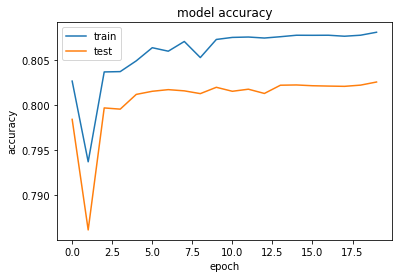

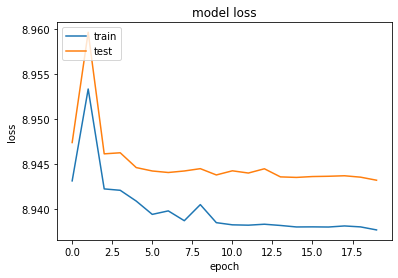

In [45]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file = "seq2seq_translation.png", show_shapes = True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Evaluation

In [156]:
eval_loss, eval_acc = model2.evaluate(test)

print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

50/50 [==============================] - 6s 111ms/step - loss: 8.9432 - accuracy: 0.8026

Eval loss: 8.943, Eval accuracy: 0.803


In [96]:
text1 = en_data.take(5)

In [97]:
next(iter(test1))

(<tf.Tensor: shape=(20, 92), dtype=int32, numpy=
 array([[ 3034, 13181, 12240, ...,     0,     0,     0],
        [ 3223,  8463,  9991, ...,     0,     0,     0],
        [ 9894,  7668,  9550, ...,     0,     0,     0],
        ...,
        [ 5845,  9663,  8546, ...,     0,     0,     0],
        [ 3341,  1965,  7706, ...,     0,     0,     0],
        [  882,  7624,   283, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(20, 104), dtype=int32, numpy=
 array([[12548, 12750,  6124, ...,     0,     0,     0],
        [  336,  1337, 15824, ...,     0,     0,     0],
        [ 8191, 16250,  1668, ...,     0,     0,     0],
        ...,
        [ 3177,  1060,  5453, ...,     0,     0,     0],
        [ 3512,  6879,  2458, ...,     0,     0,     0],
        [ 1337,  5158,  8630, ...,     0,     0,     0]])>)

In [139]:
text_inputs = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[0]), 'r', encoding='utf-8') as en_file:
    input_text = en_file.readlines()
    en_file.close() 
print(input_text[0:5])
input_text = input_text[0:5]

['so too does the idea that accommodating religious differences is dangerous\n', 'mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be\n', 'reserve should turn into thought - provoking policy\n', 'it is my profound belief that we can only advance through cooperation and negotiation\n', 'the european union has territorial waters greater than its entire territory with 1 200 ports and 90 % of its exports are transported by sea\n']


In [140]:
with open("text_inputs.txt", "w", encoding='utf-8') as in_file:
    in_file.writelines(input_text)
    in_file.close()

In [141]:
targets = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[1]), 'r', encoding='utf-8') as fr_file:
    targets = fr_file.readlines()
    fr_file.close() 
print(targets[0:5])
targets = targets[0:5]

['l ’ idée de concilier les différences religieuses semble donc dangereuse\n', 'monsieur le président mesdames et messieurs les perspectives financières esquissent la portée des activités de l ’ ue pour les années à venir fournissent un cadre pour ces activités et déterminent leur efficacité\n', 'la réticence doit laisser place à une politique stimulante\n', 'je suis intimement convaincu que nous ne pourrons progresser que si nous coopérons et négocions\n', "le territoire marin de l ' union européenne est plus vaste que son territoire terrestre on y dénombre 1 200 ports et 90 % de ses exportations sont acheminées par mer\n"]


In [146]:
with open("targets.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(targets)
    target_file.close()

In [153]:
from pathlib import Path
args_input_file_path = "text_inputs.txt"

# Load text input

file_to_open = Path(args_input_file_path)
f = open(file_to_open)
d = tf.data.TextLineDataset(args_input_file_path)
next(iter(d))

<tf.Tensor: shape=(), dtype=string, numpy=b'so too does the idea that accommodating religious differences is dangerous'>

In [150]:
f.close()

In [155]:
from pathlib import Path

# Load model parameters
model2.load_weights("baseline1.2.h5")
args_input_file_path = "text_inputs.txt"
pred_file_path = "predictions.txt"

# Load text input
data_input = tf.data.TextLineDataset(args_input_file_path)

# Encode text
encode_input = data_input.map(encode_map_en)

# Paddind
pad_input = pad_sequences(list(encode_input), maxlen=en_max_len, padding='post')

# Run prediction
predictions = np.argmax(model2.predict(pad_input), axis=2)

sequences = []
for prediction in predictions:
    sequence = ' '.join([list(fr_vocab)[index] for index in prediction if index > 0])
    print(sequence)
    sequences.append(sequence)
np.savetxt(pred_file_path, sequences, fmt='%s')

qualifierai requins requins culture culture culture culture culture culture
qualifierai requins requins culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture
renforcer requins requins culture culture culture
renforcer requins requins culture culture culture culture culture culture culture culture culture
requins requins requins culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture culture


In [162]:
def generate_predictions(input_file_path, pred_file_path):
    # load model's parameters
    
    # Load input text
    
    # Preprocess input text (tokenized, encoded, padded)
    
    # Run prediction
    
    # Save to file
    
    # Run Evaluator.py
    
    return None
    

## SacreBLEU Evaluation 
['1.9', '0.6', '2.5', '1.3', '0.6', '']

final avg bleu score: 1.38